#  `DiscreteLogPrior` and Simulations

If you look at/remember the Instrument Response Functions tutorial you will remember that our initial goal with `GammaBayes` was to calculate the following.

\begin{equation}

\newcommand{\Idepend}{\mathbf{obs}}
\newcommand{\Mdepend}{\mathcal{M}_i, \vec{\phi}_i, \mathcal{M}_\alpha}
\newcommand{\kdatum}{\{E, \vec{\Omega}\}_k}
\newcommand{\kdatumtrue}{\{E^t, \vec{\Omega^t}\}_k}
\newcommand{\parameters}{\{\vec{\theta_i}\}_i, \vec{\alpha}}


\newcommand{\likelihood}{\mathcal{L}(\kdatum | \kdatumtrue, \Idepend)}

\newcommand{\prior}{\pi(\kdatumtrue |\mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \text{exposure})}

\newcommand{\evidence}{\mathcal{Z}(\kdatum | \mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \Idepend)}

\newcommand{\posterior}{p(\kdatumtrue |\kdatum, \mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \Idepend)}

\evidence = \int_{E^t} dE^t \int_{\Omega^t} d\Omega^t \; \likelihood \prior \nonumber

\end{equation}

We have already gone through the likelihood in this and how `GammaBayes` handles it through the `IRF_LogLikelihood` class but we haven't talked about the prior, $\pi(\{E^t, \Omega^t\}_k|\mathcal{M}_i, \vec{\theta}_i, \vec{\phi}_i, \text{exposure})$, very much.

In this form the prior is where our astrophysical source models come into our calculations. In this way they are handled by the `DiscreteLogPrior` class. Once writing up the majority of this pipeline I realised that there are actually a second set of priors put on the hyperparameters, these priors on the _hyper-parameters_ of the prior distributions are handled by the `Parameter`, `ParameterSet` and `ParameterSetCollection` classes (yes really Parameter-Set-Collection, I talk about the reasoning for this naming in the relevant tutorial). For now we do not need these so we will focus on the `DiscreteLogPrior` class.

## `DiscreteLogPrior`

As previously stated this class takes in an astrophysical flux model, a set of parameters (and if you're feeling fancy a default set of parameters) and packages it into a prior for use within `GammaBayes`. I'll begin with a couple custom instantiations of the class, a couple sub-classes for more specific purposes and some `GammaBayes` defaults that you can use in your own analysis.

We'll begin with a similar function that was used in the `GammaObs` and `GammaObsCube` tutorial, a 2D gaussian in the angular dimensions and then a 1D gaussian in log-energy.

In [1]:
from scipy.stats import norm, multivariate_normal
import numpy as np
from astropy import units as u

def log_astro_flux(energy, lon, lat, spectral_parameters:dict={}, spatial_parameters:dict={}):


    energy_unit = energy.unit
    lon_unit = lon.unit
    lat_unit = lat.unit
    energy, lon, lat = np.asarray(energy.value)*energy_unit, np.asarray(lon.value)*lon_unit, np.asarray(lat.value)*lat_unit



    spectral_defaults = {'mu':10.0, 'scale':3.}
    spatial_defaults = {'central_coord':np.array([0,0.])*u.deg, 'scale':1.0}

    for key, value in spectral_defaults.items():
        spectral_parameters.setdefault(key, value)

    for key, value in spatial_defaults.items():
        spatial_parameters.setdefault(key, value)

    coords = np.stack([lon.to('deg').value.flatten(), lat.to('deg').value.flatten()], axis=-1)


    log_spec_pdf_val = norm(loc=spectral_parameters['mu'], scale=spectral_parameters['scale']).logpdf(energy.to('TeV').value.flatten())
    log_spat_pdf_val = multivariate_normal(mean=[coord.value for coord in spatial_defaults['central_coord']], cov=spatial_defaults['scale']*np.identity(2)).logpdf(coords)


    output = log_spec_pdf_val+log_spat_pdf_val+np.log(1e4)

    try:
        output = output.reshape(energy.shape)
        return output    
    except:
        return output

Most of the difficulty from the above comes from three things:
1. Enforced astropy units. I require that all flux models must be able to in take energy, longitude and latitude values with relevant astropy units, they don't have to be TeV but at least something.

2. How defaults are handled with dictionaries. The reason that the defaults are split into two here is because many models can have independent energy and spatial distributions, and it is much more efficient to make the user specify what parameters go to which part then require that all parameter values be unique and sort through the keyword arguments within the code and apply them properly to the respective part plus a couple hundred other things that I could not see the merit in doing. If you disagree then feel free to send an email I'm always up for some good refactoring.

3. Scipy distributions can have annoying inputs


So the main things are that your function has three arguments for energy, longitude and latitude (preferably with the same naming but if you want to change it feel free, I just don't test for that) and it is required to have spectral_parameters and spatial_parameters. Future updates may then take any leftover keyword arguments and apply them to a combined dictionary, but for now if your prior is a single function that cannot be split into two I just recommend making your function take the relevant keywords from either dictionary.

But that is the once that formatting is done, that is the hardest thing that you have to do to essentially run most of `GammaBayes` and most certainly this notebook. 

Let's chuck this into an instance of `DiscreteLogPrior`.

In [2]:
from gammabayes.priors import DiscreteLogPrior
from gammabayes import GammaBinning

true_binning_geometry = GammaBinning(energy_axis=np.logspace(-1,2,181)*u.TeV, lon_axis=np.linspace(-4, 4, 81)*u.deg, lat_axis=np.linspace(-3, 3, 61)*u.deg)

example_log_prior = DiscreteLogPrior(logfunction=log_astro_flux, binning_geometry=true_binning_geometry)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


`DiscreteLogPrior` honestly does not do much, it essentially serves as a way to enforce a standard wrapper on functions of your choice so that they can run in whatever `GammaBayes` function/method/class whatever. For now we will just go through the methods and attributes one-by-one and see what they do and how you can use them.

### `construct_prior_array` and `log_normalisation`

`construct_prior_array` is essentially a method to evaluate your prior on the whole binning geometry for one or multiple sets of parameters. 

e.g. If you call it without any arguments it will just output the outputs of your function on the binning geometry.

In [3]:
log_matrix_values = example_log_prior.construct_prior_array()
log_matrix_values.shape, example_log_prior.binning_geometry.lon_axis.value.shape, example_log_prior.binning_geometry.lat_axis.value.shape
applied_normalisation=False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


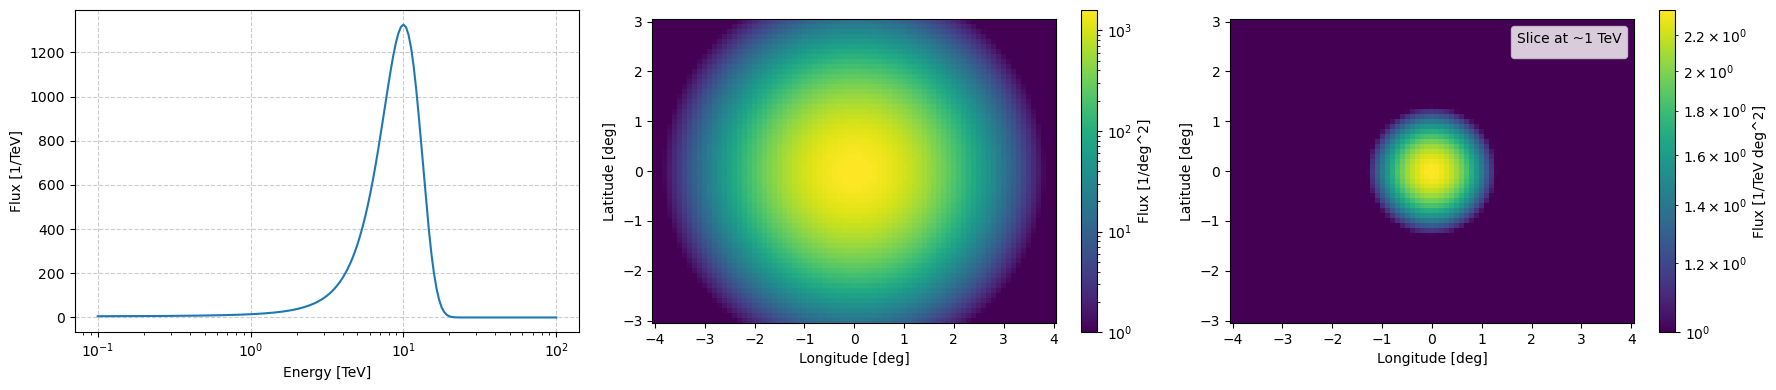

In [4]:
from matplotlib import pyplot as plt
from gammabayes.utils.integration import iterate_logspace_integration


fig, ax = plt.subplots(1,3, figsize=(18,4))

log_integrated_energy_flux = iterate_logspace_integration(logy=log_matrix_values, 
                                        axes=[example_log_prior.binning_geometry.lon_axis.value, example_log_prior.binning_geometry.lat_axis.value],
                                        axisindices=[1,2])

log_integrated_spatial_flux = iterate_logspace_integration(logy=log_matrix_values, 
                                        axes=[example_log_prior.binning_geometry.energy_axis.value],
                                        axisindices=[0])


ax[0].plot(example_log_prior.binning_geometry.energy_axis.value, np.exp(log_integrated_energy_flux))
ax[0].set_xscale('log')
ax[0].set_xlabel('Energy [TeV]')
ax[0].set_ylabel('Flux [1/TeV]')
ax[0].grid(which='major', c='grey', ls='--', alpha=0.4)


pcm = ax[1].pcolormesh(example_log_prior.binning_geometry.lon_axis.value, 
                 example_log_prior.binning_geometry.lat_axis.value, 
                 np.exp(log_integrated_spatial_flux.T),
                 vmin=1,
                 norm='log')
ax[1].set_aspect('equal')
ax[1].set_xlabel('Longitude [deg]')
ax[1].set_ylabel('Latitude [deg]')
plt.colorbar(mappable=pcm, label='Flux [1/deg^2]', ax=ax[1])



pcm = ax[2].pcolormesh(example_log_prior.binning_geometry.lon_axis.value, 
                 example_log_prior.binning_geometry.lat_axis.value, 
                 np.exp(log_matrix_values[np.abs(example_log_prior.binning_geometry.energy_axis.value-1).argmin(), :, :].T),
                 vmin=1,
                 norm='log')
ax[2].set_aspect('equal')
ax[2].set_xlabel('Longitude [deg]')
ax[2].set_ylabel('Latitude [deg]')
plt.colorbar(mappable=pcm, label='Flux [1/TeV deg^2]', ax=ax[2])
ax[2].legend(title="Slice at ~1 TeV")


plt.tight_layout()
plt.show()


And then you can call `log_normalisation` to calculate the integral of your function over the bin geometry which if we apply to the above we get a probability density for the values of events the model would emit.

In [5]:
if not applied_normalisation:
    log_normalisation = example_log_prior.log_normalisation()
    log_matrix_values = log_matrix_values - log_normalisation
    applied_normalisation = True

np.exp(log_normalisation)

9969.766189735285

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


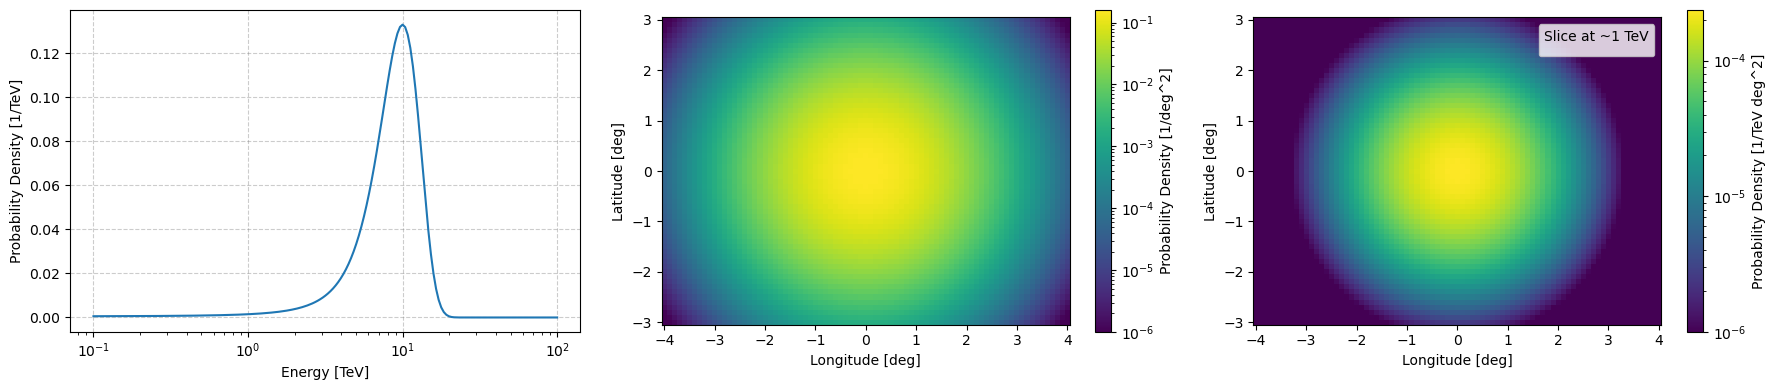

In [6]:

fig, ax = plt.subplots(1,3, figsize=(18,4))

log_integrated_energy_flux = iterate_logspace_integration(logy=log_matrix_values, 
                                        axes=[example_log_prior.binning_geometry.lon_axis.value, example_log_prior.binning_geometry.lat_axis.value],
                                        axisindices=[1,2])

log_integrated_spatial_flux = iterate_logspace_integration(logy=log_matrix_values, 
                                        axes=[example_log_prior.binning_geometry.energy_axis.value],
                                        axisindices=[0])


ax[0].plot(example_log_prior.binning_geometry.energy_axis.value, np.exp(log_integrated_energy_flux))
ax[0].set_xscale('log')
ax[0].set_xlabel('Energy [TeV]')
ax[0].set_ylabel('Probability Density [1/TeV]')
ax[0].grid(which='major', c='grey', ls='--', alpha=0.4)


pcm = ax[1].pcolormesh(example_log_prior.binning_geometry.lon_axis.value, 
                 example_log_prior.binning_geometry.lat_axis.value, 
                 np.exp(log_integrated_spatial_flux.T),
                 vmin=1e-6,
                 norm='log')
ax[1].set_aspect('equal')
ax[1].set_xlabel('Longitude [deg]')
ax[1].set_ylabel('Latitude [deg]')
plt.colorbar(mappable=pcm, label='Probability Density [1/deg^2]', ax=ax[1])



pcm = ax[2].pcolormesh(example_log_prior.binning_geometry.lon_axis.value, 
                 example_log_prior.binning_geometry.lat_axis.value, 
                 np.exp(log_matrix_values[np.abs(example_log_prior.binning_geometry.energy_axis.value-1).argmin(), :, :].T),
                 vmin=1e-6,
                 norm='log')
ax[2].set_aspect('equal')
ax[2].set_xlabel('Longitude [deg]')
ax[2].set_ylabel('Latitude [deg]')
plt.colorbar(mappable=pcm, label='Probability Density [1/TeV deg^2]', ax=ax[2])
ax[2].legend(title="Slice at ~1 TeV")


plt.tight_layout()
plt.show()


Or you skip applying it and just call the `construct_prior_array` with the `normalise` argument set to `True`

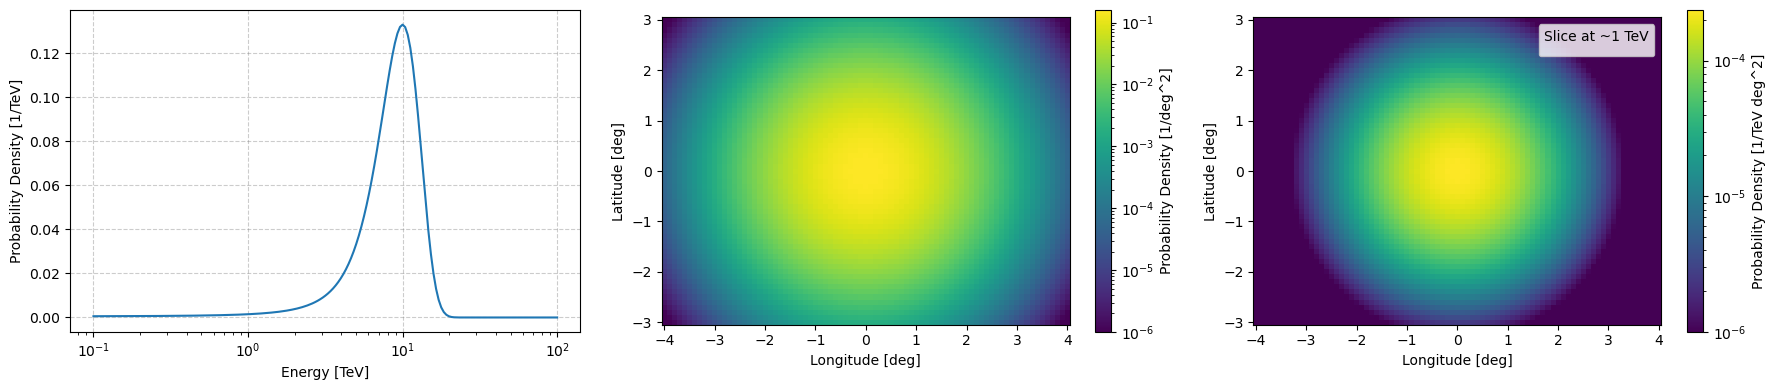

In [7]:
log_matrix_values = example_log_prior.construct_prior_array(normalise=True)


fig, ax = plt.subplots(1,3, figsize=(18,4))
log_integrated_energy_flux = iterate_logspace_integration(logy=log_matrix_values, 
                                        axes=[example_log_prior.binning_geometry.lon_axis.value, example_log_prior.binning_geometry.lat_axis.value],
                                        axisindices=[1,2])

log_integrated_spatial_flux = iterate_logspace_integration(logy=log_matrix_values, 
                                        axes=[example_log_prior.binning_geometry.energy_axis.value],
                                        axisindices=[0])

ax[0].plot(example_log_prior.binning_geometry.energy_axis.value, np.exp(log_integrated_energy_flux))
ax[0].set_xscale('log')
ax[0].set_xlabel('Energy [TeV]')
ax[0].set_ylabel('Probability Density [1/TeV]')
ax[0].grid(which='major', c='grey', ls='--', alpha=0.4)

pcm = ax[1].pcolormesh(example_log_prior.binning_geometry.lon_axis.value, 
                 example_log_prior.binning_geometry.lat_axis.value, 
                 np.exp(log_integrated_spatial_flux.T),
                 vmin=1e-6,
                 norm='log')
ax[1].set_aspect('equal')
ax[1].set_xlabel('Longitude [deg]')
ax[1].set_ylabel('Latitude [deg]')
plt.colorbar(mappable=pcm, label='Probability Density [1/deg^2]', ax=ax[1])



pcm = ax[2].pcolormesh(example_log_prior.binning_geometry.lon_axis.value, 
                 example_log_prior.binning_geometry.lat_axis.value, 
                 np.exp(log_matrix_values[np.abs(example_log_prior.binning_geometry.energy_axis.value-1).argmin(), :, :].T),
                 vmin=1e-6,
                 norm='log')
ax[2].set_aspect('equal')
ax[2].set_xlabel('Longitude [deg]')
ax[2].set_ylabel('Latitude [deg]')
plt.colorbar(mappable=pcm, label='Probability Density [1/TeV deg^2]', ax=ax[2])
ax[2].legend(title="Slice at ~1 TeV")


plt.tight_layout()
plt.show()


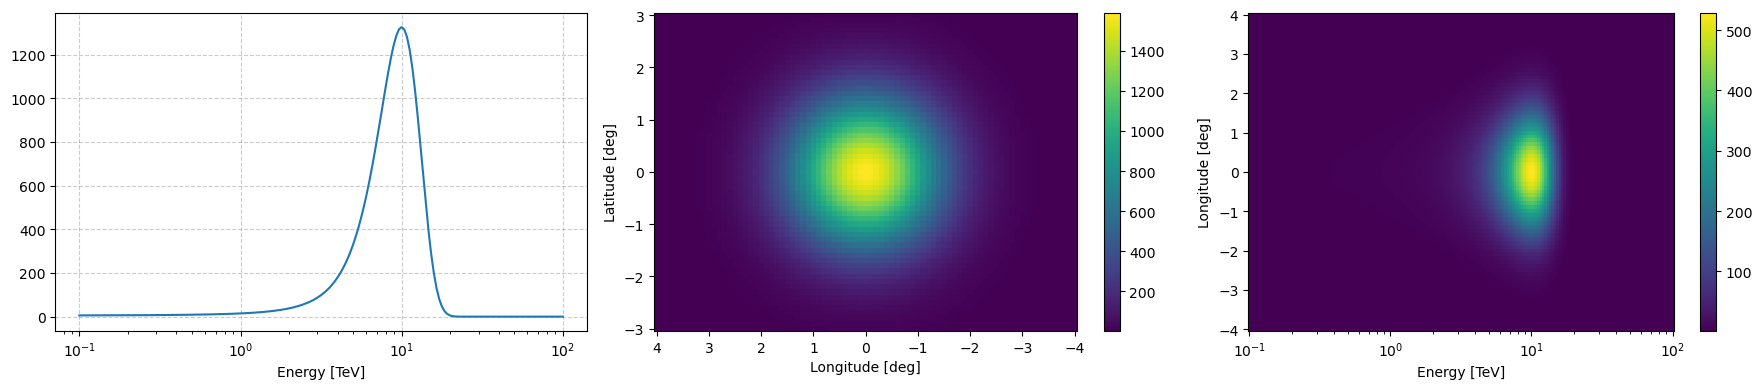

In [8]:
example_log_prior.peek(figsize=(18,4), vmin=1)
plt.show()

### `__call__`

You can also just call the class as you would with the function that you gave to the class.

In [9]:
example_log_value = example_log_prior(1*u.TeV, 0*u.deg, 0*u.deg)

example_log_value, np.exp(example_log_value)

(0.854912483694056, 2.3511686059796704)

### `log_scaling_factor`

And oftentimes you may want to change the scale of the unnormalised values for which there is a `log_scaling_factor` attribute.

In [10]:
example_log_prior.log_scaling_factor

0.0

In [11]:
example_log_prior.rescale(np.log(2))

In [12]:
example_log_value = example_log_prior(1*u.TeV, 0*u.deg, 0*u.deg)

example_log_value, np.exp(example_log_value)

(1.5480596642540014, 4.702337211959341)

### `sample` and Simulations

#### Generating true value samples

Then finally we get to how you can simulate based on given models. Just call the `sample` method with the number of events that you require or if left as None it will use the normalisation as an estimate.

In [13]:
normalisation_sample_obs = example_log_prior.sample()
specified_number_sample_obs = example_log_prior.sample(int(1e3))

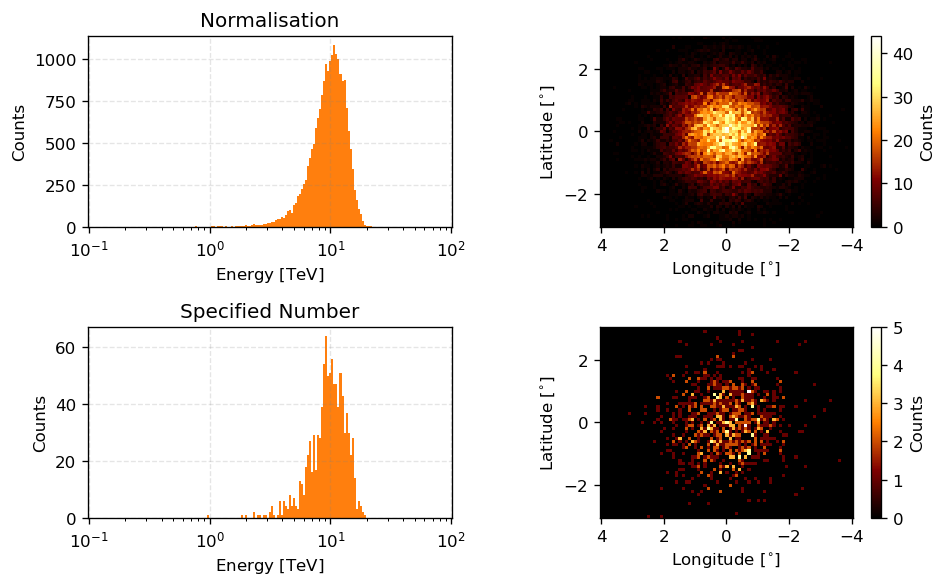

In [14]:
fig, ax  = plt.subplots(2, 1, figsize=(8,5), dpi=120)

ax[0].set_title("Normalisation")
newax = normalisation_sample_obs.peek(axs=ax[0])
newax[0].set_title("Normalisation")


newax = specified_number_sample_obs.peek(axs=ax[1])
newax[0].set_title("Specified Number")

plt.tight_layout()
plt.show()

So the above are samples of the priors which are functions of the true event values $E^t$ and $\Omega^t$ but a telescope does not measure this. To make these samples representative of measurement values we need to add noise to them reflecting the noise that the instrument introduces.

This can be done with the use of the Instrument Response Functions. Remember that one (or the) definition of the IRFs are they are the probabilities of what the instrument will reconstruct given a set of true values... well we have the sets of true parameters. We can then sample the probability distribution of the IRFs to get data representative of measured values.

## Adding noise to true values with `IRF_LogLikelihood`

`IRF_LogLikelihood` has two methods for sampling both inherited from the base `DiscreteLogLikelihood` class. `raw_sample` deals with the raw samples on a per event level. So you can pass it a set of true values and how many events shared these values to get a set of measured values in a `GammaObs` instance.

First we need an `IRF_LogLikelihood` instance to do this with. Again, we'll say the pointing direction is the Galactic Centre with an observation time of 0.5 hours.

In [15]:
from gammabayes.likelihoods.irfs import IRF_LogLikelihood

recon_binning_geometry = GammaBinning(energy_axis=np.logspace(-1,2,91)*u.TeV, lon_axis=np.linspace(-4, 4, 41)*u.deg, lat_axis=np.linspace(-3, 3, 31)*u.deg)

irf_loglike = IRF_LogLikelihood(
    pointing_dir=np.array([0.,0.])*u.deg,
    observation_time=0.5*u.hr,
    binning_geometry=recon_binning_geometry, true_binning_geometry=true_binning_geometry)


We can then pick out a set of true values from above and how many events shared those values. We'll pick one with more than 1 event.

In [16]:
nonzero_specified_number_samples = specified_number_sample_obs.nonzero_bin_data

indices_where_more_than_1 = np.where(nonzero_specified_number_samples[1]>1)[0]

example_raw_coord = nonzero_specified_number_samples[0][indices_where_more_than_1[0]]
example_raw_coord_num_events = nonzero_specified_number_samples[1][indices_where_more_than_1[0]]

example_raw_coord, example_raw_coord_num_events

(array([<Quantity 8.25404185 TeV>, <Quantity -0.7 deg>,
        <Quantity -0.9 deg>], dtype=object),
 2.0)

We can then generate some measured values by putting in `example_raw_coord` as our dependent values (remembering that the IRFs are probabilities over the measured values with a _dependency_ on the true values) and the number of events as the number of samples.

In [17]:
raw_measured_event_samples = irf_loglike.raw_sample(dependentvalues=example_raw_coord, numsamples=int(example_raw_coord_num_events))

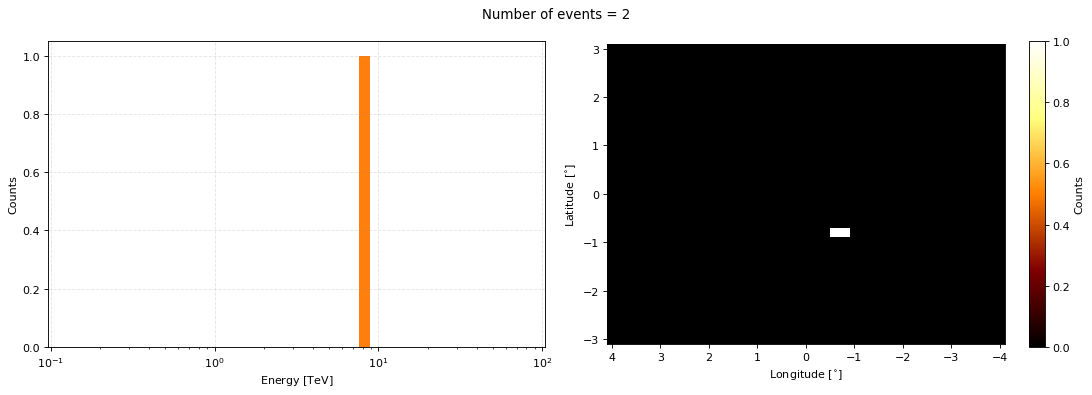

In [18]:
axs = raw_measured_event_samples.peek(figsize=(14,5), dpi=80)

fig = axs[0].get_figure()

fig.suptitle(f"Number of events = {len(raw_measured_event_samples.energy)}")
plt.tight_layout()

One would then have to loop through all the true values and generate the subsequent measured values. However, the second method `sample` can take in a `GammaObs` instance and output a `GammaObs` instance with the measured values for all the events. 

This will take up to a minute as for every true value we need to generate the array of measured values and then sample that array. So let's say we have 500 unique events, then the sampling routine need to generate 500*(size of recon energy axis)*(size of recon longitude axis)*(size of recon latitude axis) values.

It is trivially/embarassingly parallelizable though if you batch your data but I don't want to over-complicate things here.

In [19]:
measured_event_samples = irf_loglike.sample(specified_number_sample_obs, print_progress=True)

100%|██████████| 987/987 [01:26<00:00, 11.39it/s]


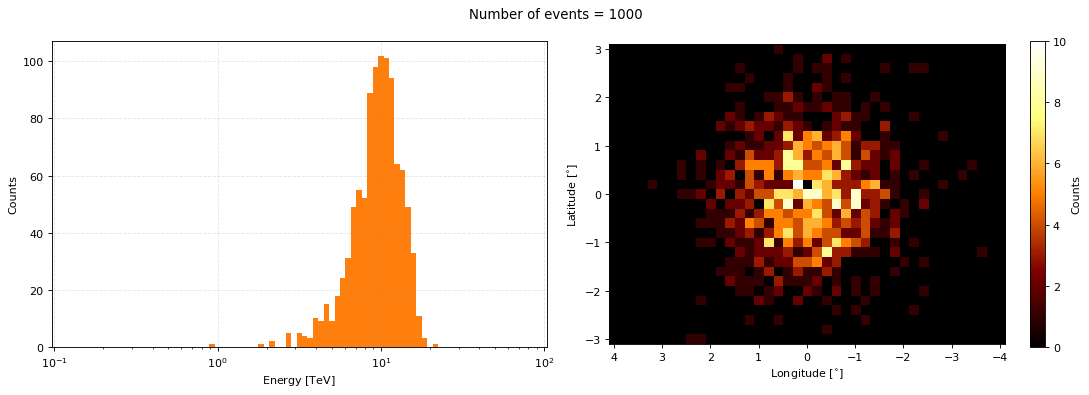

In [20]:
axs = measured_event_samples.peek(figsize=(14,5), dpi=80)

fig = axs[0].get_figure()

fig.suptitle(f"Number of events = {len(measured_event_samples.energy)}")
plt.tight_layout()

We now have data representative of our astrophysical flux model when observed by CTAO! But there is something strange things about what we've just done... We did not take into account exposure! 

There was no point where we would say we got our data from 5 hours of observations or 0.5 hours?? The 0.5 hours we specified for the IRF was just to get some version of the energy dispersion and point spread function not the exposure. Additionally, what if we were pointing at some other location in the sky such that there was no way that we would actually get event data from this source?

In `GammaBayes` we require that the priors used as above already take into account exposure, we do not necessarily ask you to do this yourself though, there are a few sub-classes that will help you out if you don't want to handle the exposure yourself.

## `SourceFluxDiscreteLogPrior`

Once instantiated there is not many real differences between `DiscreteLogPrior` and `SourceFluxDiscreteLogPrior`. 

Has the same inputs and outputs except that you must either specify a pointing direction, observation time and `IRF_LogLikelihood` instance (for the effective area) or pass in a `GammaLogExposure` instance to account for exposure and we specify the `log_flux_function` instead of `logfunction`. Let's pretend that our above flux model is exactly that, an astrophysical flux model where to get the rate of events detected by an instrument such as CTAO we must apply the exposure. 

Let's specify that the pointing direction is _actually_ the Galactic Centre with an observation time of 0.5 hours.

In [21]:
from gammabayes.priors import SourceFluxDiscreteLogPrior

example_source_flux_prior = SourceFluxDiscreteLogPrior(log_flux_function=log_astro_flux, 
                                                        irf_loglike=irf_loglike,
                                                       binning_geometry=true_binning_geometry, 
                                                       pointing_dir=np.array([0.,0.])*u.deg,
                                                       observation_time=0.5*u.hr)

(<Figure size 1200x300 with 5 Axes>,
 array([<Axes: xlabel='Energy [TeV]'>,
        <Axes: xlabel='Longitude [deg]', ylabel='Latitude [deg]'>,
        <Axes: xlabel='Energy [TeV]', ylabel='Longitude [deg]'>],
       dtype=object))

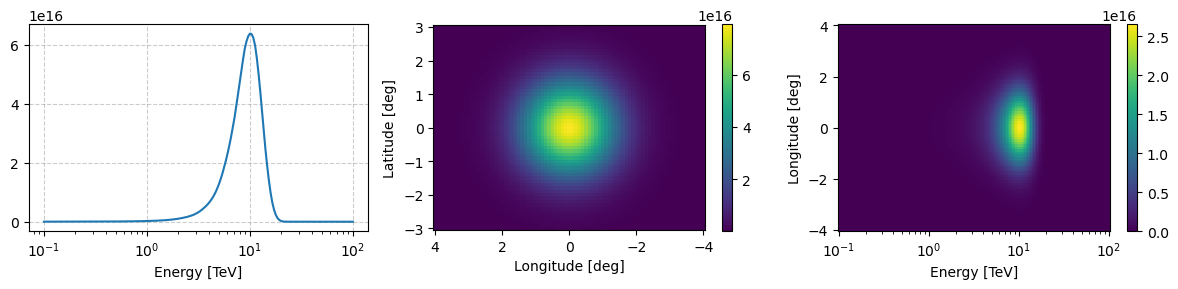

In [22]:
example_source_flux_prior.peek(figsize=(12,3))

You can see there's not much of a difference between what we had before and now besides that the overall flux seems larger because our observation is relatively small. 

If we made is significantly larger than the effective area would default to zero at some angular offset and the number of events from outside that region would be zero.

But now we can ask, what if our pointing direction was at (-3,0)? How would observations of our source be impacted?

In [23]:
example_source_flux_prior_bad_pointing = SourceFluxDiscreteLogPrior(log_flux_function=log_astro_flux, 
                                                                    irf_loglike=irf_loglike,
                                                       binning_geometry=true_binning_geometry, 
                                                       pointing_dir=np.array([-3.,0.])*u.deg,
                                                       observation_time=5*u.hr)

(<Figure size 1200x300 with 5 Axes>,
 array([<Axes: xlabel='Energy [TeV]'>,
        <Axes: xlabel='Longitude [deg]', ylabel='Latitude [deg]'>,
        <Axes: xlabel='Energy [TeV]', ylabel='Longitude [deg]'>],
       dtype=object))

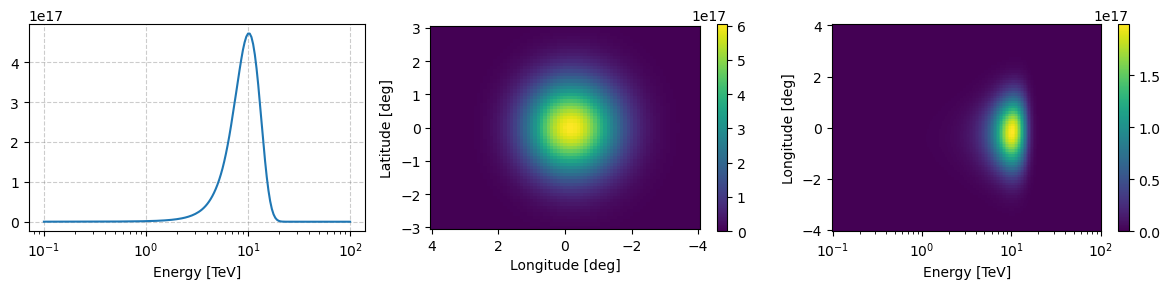

In [24]:
example_source_flux_prior_bad_pointing.peek(figsize=(12,3))

You can see that approximately 4 degrees away from the pointing direction the flux of events drops to zero, reflecting where CTAO can accurately reconstruct data. We can confirm this by looking at the `log_exposure_map` attribute of the source flux prior.

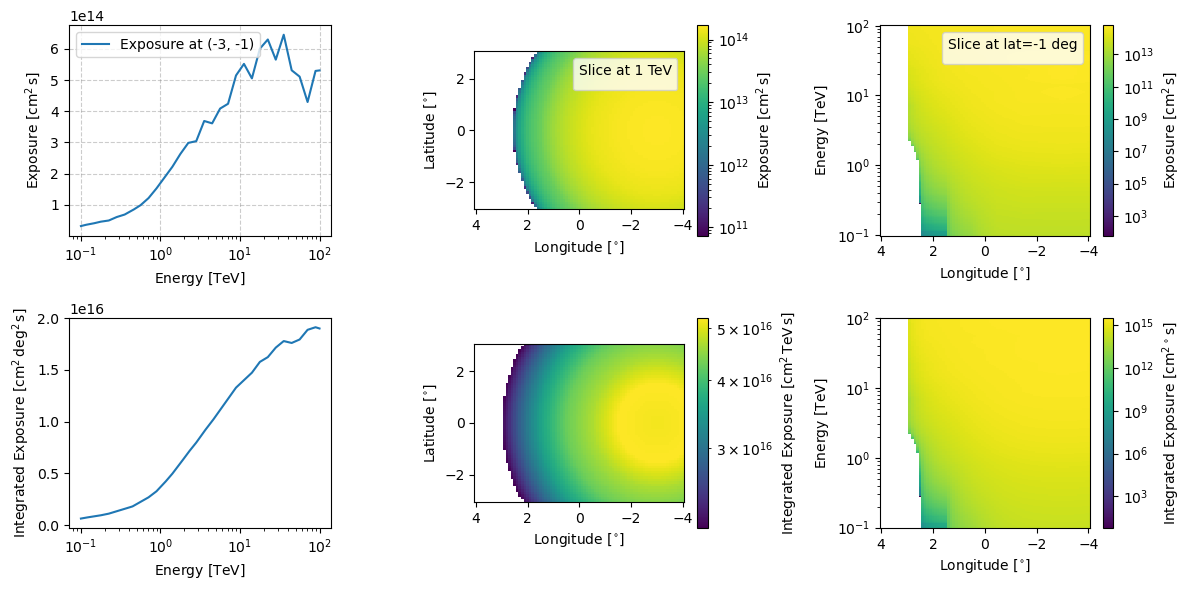

In [25]:
example_source_flux_prior_bad_pointing.log_exposure_map.peek(figsize=(12,6))
plt.show()

From this we also expect the energy distribution to be slightly shifted to the right due to the effective area but that is harder to see by eye.

## `TwoCompFluxPrior`

`TwoCompFluxPrior` is again very similar to `SourceFluxDiscreteLogPrior` (due to it being a child class of it) but we can separately specify the energy and spatial distributions. This is handy for things like dark matter source fluxes where the spectral and spatial distributions are usually assumed to be relatively independent.

Let's re-cast our original prior into an energy distribution and spatial distribution. 


We need to make them classes as at this level of specificity we can get some good optimisations by whether a mesh efficieny version of the class exists where if you want to evaluate on the binning geometry you can evaluate on the energy axis and the spatial axes separately vastly decreasing computation time.

And implementing this with a class was the easiest option. If it has a functions `mesh_efficient_logfunc` for both the spectral and spatial distributions then it allows access to mesh efficient methods during sample and constructing the prior matrices.

In [26]:

class example_spectral_class:

    def log_func(self, energy, kwd_parameters:dict={}):


        energy_unit = energy.unit
        energy = np.asarray(energy.value)*energy_unit



        defaults = {'mu':10.0, 'scale':3.}

        for key, value in defaults.items():
            kwd_parameters.setdefault(key, value)


        log_spec_pdf_val = norm(loc=kwd_parameters['mu'], scale=kwd_parameters['scale']).logpdf(energy.to('TeV').value.flatten())


        output = log_spec_pdf_val

        try:
            output = output.reshape(energy.shape)
            return output    
        except:
            return output
        
    def mesh_efficient_logfunc(self, energy, kwd_parameters:dict={}):
        
        mesh_of_parameters = np.meshgrid(energy, *kwd_parameters.values(), indexing='ij')

        output = self.log_func(mesh_of_parameters[0].flatten(), 
                               kwd_parameters = {
                                   key:value.flatten() for key, value in zip(
                                       kwd_parameters.keys(), 
                                       mesh_of_parameters[1:]
                                       )}).reshape(mesh_of_parameters[0].shape)
        
        return output


    


class example_spatial_class:
    def log_func(self, lon, lat, kwd_parameters:dict={}):


        lon_unit = lon.unit
        lat_unit = lat.unit
        lon, lat = np.asarray(lon.value)*lon_unit, np.asarray(lat.value)*lat_unit



        defaults = {'central_coord':np.array([0,0.])*u.deg, 'scale':1.0}


        for key, value in defaults.items():
            kwd_parameters.setdefault(key, value)

        coords = np.stack([lon.to('deg').value.flatten(), lat.to('deg').value.flatten()], axis=-1)


        log_spat_pdf_val = multivariate_normal(mean=[coord.value for coord in kwd_parameters['central_coord']], cov=kwd_parameters['scale']*np.identity(2)).logpdf(coords)


        output = log_spat_pdf_val+np.log(1e4)

        try:
            output = output.reshape(lon.shape)
            return output    
        except:
            return output
        

    def mesh_efficient_logfunc(self, lon, lat, kwd_parameters:dict={}):
        
        mesh_of_parameters = np.meshgrid(lon, lat, *kwd_parameters.values(), indexing='ij')

        output = self.log_func(mesh_of_parameters[0].flatten(), 
                               mesh_of_parameters[1].flatten(), 
                               kwd_parameters = {
                                   key:value.flatten() for key, value in zip(
                                       kwd_parameters.keys(), 
                                       mesh_of_parameters[2:]
                                       )}).reshape(mesh_of_parameters[0].shape)
        
        return output

Again, that the hardest part about all this is just getting the format of the initial inputs correct and then it should just run. Hopefully with the help of the tutorials it isn't too much of an issue but if you need help feel free to raise a discussion on the GitHub repo.

Now let's instantiate the class with a pointing direction of (-6,0) so we can very easily see the effect of the exposure once we get some samples out of it.

(<Figure size 1000x300 with 5 Axes>,
 array([<Axes: xlabel='Energy [TeV]'>,
        <Axes: xlabel='Longitude [deg]', ylabel='Latitude [deg]'>,
        <Axes: xlabel='Energy [TeV]', ylabel='Longitude [deg]'>],
       dtype=object))

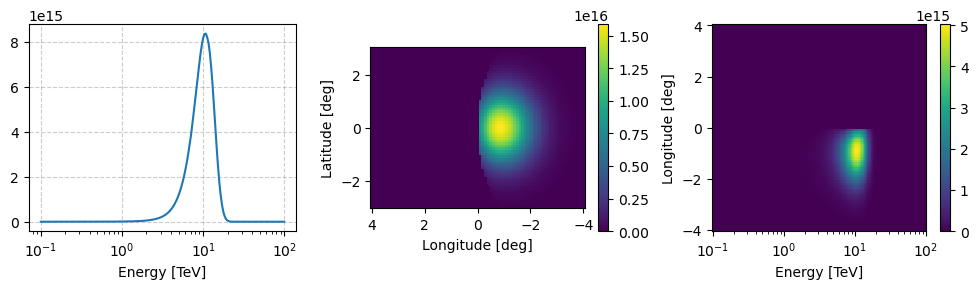

In [27]:
from gammabayes.priors import TwoCompFluxPrior


two_comp_prior = TwoCompFluxPrior(spectral_class=example_spectral_class,
                                  spatial_class=example_spatial_class,
                                  binning_geometry=true_binning_geometry,
                                  irf_loglike=irf_loglike,
                                  pointing_dir=np.array([-6.,0.])*u.deg,
                                  observation_time=0.5*u.hr)

two_comp_prior.peek(figsize=(10,3))

array([<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Counts'>,
       <Axes: xlabel='Longitude [$\\mathrm{{}^{\\circ}}$]', ylabel='Latitude [$\\mathrm{{}^{\\circ}}$]'>],
      dtype=object)

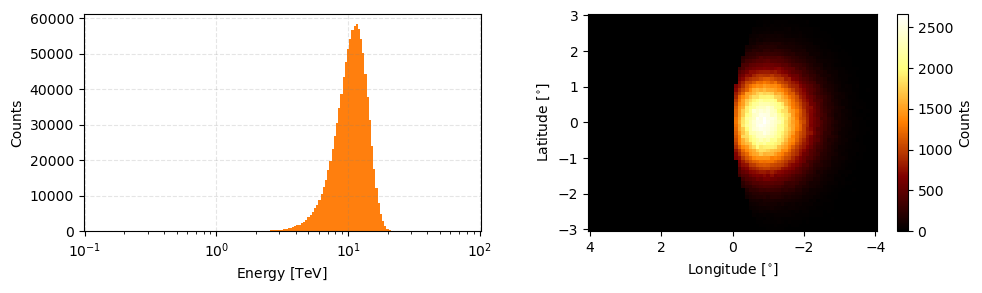

In [28]:
two_comp_obs = two_comp_prior.sample(1e6)

two_comp_obs.peek(figsize=(10,3))

## `ObsFluxDiscreteLogPrior`

The final sub-class is relatively specific for priors that are observational but require a simple exposure to handle observation times. At the moment `GammaBayes` primarily uses this class for the CCR residual cosmic ray background for CTAO. It instantiates the same as `SourceFluxDiscreteLogPrior` except that we explicitly ask you not to put in an instance of `GammaLogExposure` and we presume that this kind of prior has a `pointing_dir` attribute in it's functions (again mostly because the CCR background does).

Let's instantiate the residual CCR background that comes along with the IRFs. To be clear the CCR residual background is half-way between the IRFs and an actual source because it essentially measures an IACTs ability to exclude CCR events, but one could come along with a model for the flux of CCRs and account for this in a different way.

(<Figure size 1000x300 with 5 Axes>,
 array([<Axes: xlabel='Energy [TeV]'>,
        <Axes: xlabel='Longitude [deg]', ylabel='Latitude [deg]'>,
        <Axes: xlabel='Energy [TeV]', ylabel='Longitude [deg]'>],
       dtype=object))

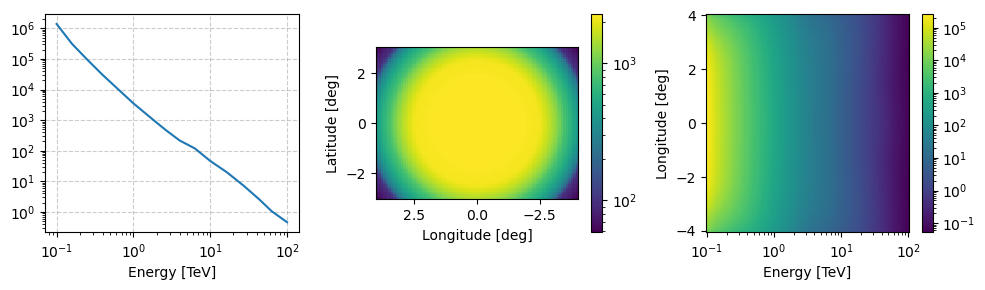

In [29]:
from gammabayes.priors import ObsFluxDiscreteLogPrior



obs_flux_prior = ObsFluxDiscreteLogPrior(logfunction=irf_loglike.log_bkg_CCR,
                                         binning_geometry=true_binning_geometry,
                                         pointing_dir=np.array([0.,0.])*u.deg,
                                         observation_time=0.5*u.hr)


obs_flux_prior.peek(figsize=(10,3), norm='log')

This class does technically have an log exposure attribute but it is just a matrix of the same dimension as the axes with the value of the observation time.

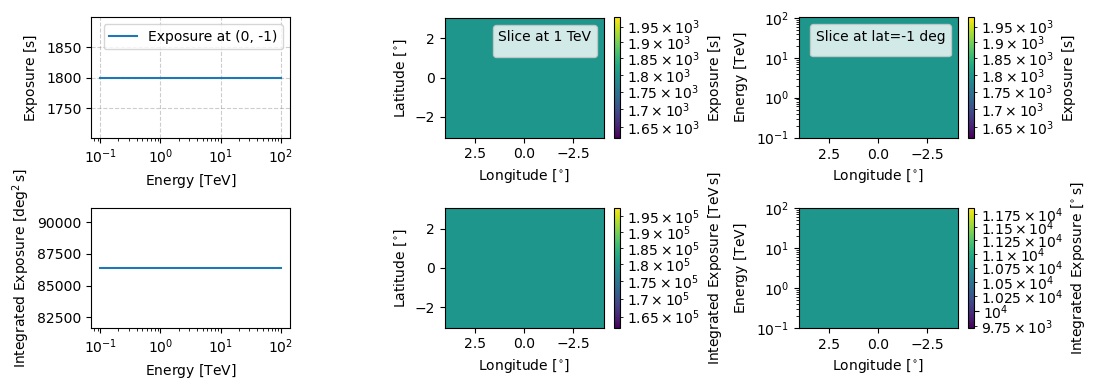

In [39]:
obs_flux_prior.log_exposure_map.peek(figsize=(11,4))
plt.show()

#### Conclusion

Now that we have a firm grasp of how priors are handled in `GammaBayes` (hopefully, if not make a discussion in the GitHub repo or send me an email) we can move on to specific in-built `GammaBayes` classes starting with those for dark matter. 

We will leave discussion of `SimContainer` which implements multi-observation simulations for when we have looked at more in-built priors.